# Import libraries and open data

In [2]:
from default import *
%cd -q {PROJECT_HOME}

from dataset import FixedPrattTrussDatasetSingleTarget
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import numpy as np

# Set dataset dirs
train_dataset_dir = r"data/dataset/pratt_truss_bridge_isostatic/0_uniform_ea"
test_dataset_dir = r"data/dataset/pratt_truss_bridge_isostatic/test"

In [10]:
def convert_dataset(filepath):
    ds = FixedPrattTrussDatasetSingleTarget(filepath)

    X = []
    y = []

    for data in ds:
        x_i, y_i, _, _, _, _ = data
        X.append(x_i)
        y.append(y_i)

    return np.array(X), np.array(y).ravel()


X_train, y_train = convert_dataset(f"{train_dataset_dir}/train_4096.hdf5")
X_validation, y_validation = convert_dataset(f"{test_dataset_dir}/0_uniform_8192.hdf5")

# Regression

In [62]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, make_scorer
from scipy.stats import loguniform, uniform
import numpy as np

# Define pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),
    ('regression', LinearRegression())
])

# Define search space
param_distributions = {
    'pca__n_components': uniform(0, 1)
}

# Halving Random Search CV
search = HalvingRandomSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring="neg_mean_absolute_percentage_error",
    n_candidates=1000,
    factor=3,
    random_state=42,
    cv=10,
    n_jobs=-1
)

# Fit the search
search.fit(X_train, y_train)

# Best model
best_pipeline = search.best_estimator_

# Predict
y_train_pred = best_pipeline.predict(X_train)
y_val_pred = best_pipeline.predict(X_validation)


# Metrics function
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true * 1e-6, y_pred * 1e-6)  # MSE in millions
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return r2, mse, rmse, mape


# Compute metrics
r2_train, mse_train, rmse_train, mape_train = compute_metrics(y_train, y_train_pred)
r2_val, mse_val, rmse_val, mape_val = compute_metrics(y_validation, y_val_pred)

# Print results
print("=== BEST HYPERPARAMETERS ===")
print(search.best_params_)

print("\n=== TRAIN SET ===")
print(f"R2     : {r2_train:.4f}")
print(f"MSE    : {mse_train:.4f} MN^2")
print(f"RMSE   : {rmse_train:.4f} MN^2")
print(f"MAPE   : {mape_train:.4%}")

print("\n=== VALIDATION SET ===")
print(f"R2     : {r2_val:.4f}")
print(f"MSE    : {mse_val:.4f} MN^2")
print(f"RMSE   : {rmse_val:.4f} MN")
print(f"MAPE   : {mape_val:.4%}")


=== BEST HYPERPARAMETERS ===
{'pca__n_components': 0.7607850486168974}

=== TRAIN SET ===
R2     : 0.3280
MSE    : 5856027.5000 MN^2
RMSE   : 2419.9231 MN^2
MAPE   : 98.8529%

=== VALIDATION SET ===
R2     : 0.3188
MSE    : 5933212.0000 MN^2
RMSE   : 2435.8186 MN
MAPE   : 99.9747%


# Ridge regression

In [64]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, make_scorer
from scipy.stats import loguniform, uniform
import numpy as np

# Define pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),
    ('regression', Ridge())
])

# Define search space
param_distributions = {
    'pca__n_components': uniform(0, 1),
    'regression__alpha': loguniform(1e-6, 1e4)
}

# Halving Random Search CV
search = HalvingRandomSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring="neg_mean_absolute_percentage_error",
    n_candidates=1000,
    factor=3,
    random_state=42,
    cv=10,
    n_jobs=-1
)

# Fit the search
search.fit(X_train, y_train)

# Best model
best_pipeline = search.best_estimator_

# Predict
y_train_pred = best_pipeline.predict(X_train)
y_val_pred = best_pipeline.predict(X_validation)


# Metrics function
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true * 1e-6, y_pred * 1e-6)  # MSE in millions
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return r2, mse, rmse, mape


# Compute metrics
r2_train, mse_train, rmse_train, mape_train = compute_metrics(y_train, y_train_pred)
r2_val, mse_val, rmse_val, mape_val = compute_metrics(y_validation, y_val_pred)

# Print results
print("=== BEST HYPERPARAMETERS ===")
print(search.best_params_)

print("\n=== TRAIN SET ===")
print(f"R2     : {r2_train:.4f}")
print(f"MSE    : {mse_train:.4f} MN^2")
print(f"RMSE   : {rmse_train:.4f} MN^2")
print(f"MAPE   : {mape_train:.4%}")

print("\n=== VALIDATION SET ===")
print(f"R2     : {r2_val:.4f}")
print(f"MSE    : {mse_val:.4f} MN^2")
print(f"RMSE   : {rmse_val:.4f} MN")
print(f"MAPE   : {mape_val:.4%}")

=== BEST HYPERPARAMETERS ===
{'pca__n_components': 0.9446142194740232, 'regression__alpha': 6.799551741277519}

=== TRAIN SET ===
R2     : 0.3348
MSE    : 5797111.5000 MN^2
RMSE   : 2407.7192 MN^2
MAPE   : 98.4369%

=== VALIDATION SET ===
R2     : 0.3255
MSE    : 5874749.0000 MN^2
RMSE   : 2423.7881 MN
MAPE   : 99.9182%


# Lasso

In [65]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import loguniform
import numpy as np

# Define pipeline with Lasso instead of Ridge
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),
    ('regression', Lasso(max_iter=10000))
])

# Define hyperparameter search space
param_distributions = {
    'pca__n_components': uniform(0, 1),
    'regression__alpha': loguniform(1e-6, 1e4)
}

# Halving Random Search CV optimizing for MAPE
search = HalvingRandomSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring="neg_mean_absolute_percentage_error",
    n_candidates=1000,
    factor=3,
    random_state=42,
    cv=10,
    n_jobs=-1
)

# Fit the model
search.fit(X_train, y_train)

# Best model
best_pipeline = search.best_estimator_

# Predict
y_train_pred = best_pipeline.predict(X_train)
y_val_pred = best_pipeline.predict(X_validation)


# Evaluation metrics
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true * 1e-6, y_pred * 1e-6)  # MSE in MN²
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return r2, mse, rmse, mape


# Compute train/val metrics
r2_train, mse_train, rmse_train, mape_train = compute_metrics(y_train, y_train_pred)
r2_val, mse_val, rmse_val, mape_val = compute_metrics(y_validation, y_val_pred)

# Display results
print("=== BEST HYPERPARAMETERS ===")
print(search.best_params_)

print("\n=== TRAIN SET ===")
print(f"R2     : {r2_train:.4f}")
print(f"MSE    : {mse_train:.4f} MN²")
print(f"RMSE   : {rmse_train:.4f} MN")
print(f"MAPE   : {mape_train:.4%}")

print("\n=== VALIDATION SET ===")
print(f"R2     : {r2_val:.4f}")
print(f"MSE    : {mse_val:.4f} MN²")
print(f"RMSE   : {rmse_val:.4f} MN")
print(f"MAPE   : {mape_val:.4%}")


/Users/aflamant/miniconda3/envs/memoire/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.647e+17, tolerance: 1.697e+16
  model = cd_fast.enet_coordinate_descent(
/Users/aflamant/miniconda3/envs/memoire/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.647e+17, tolerance: 1.697e+16
  model = cd_fast.enet_coordinate_descent(
/Users/aflamant/miniconda3/envs/memoire/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

=== BEST HYPERPARAMETERS ===
{'pca__n_components': 0.7506147516408583, 'regression__alpha': 117.04352492209394}

=== TRAIN SET ===
R2     : 0.3280
MSE    : 5856028.0000 MN²
RMSE   : 2419.9231 MN
MAPE   : 98.8529%

=== VALIDATION SET ===
R2     : 0.3188
MSE    : 5933212.5000 MN²
RMSE   : 2435.8186 MN
MAPE   : 99.9748%


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import randint, uniform
import numpy as np

# Define the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),
    ('regression', RandomForestRegressor(random_state=42))
])

# Define hyperparameter search space
param_distributions = {
    'pca__n_components': uniform(0.8, 0.2),  # tries values between 0.8 and 1.0
    'regression__n_estimators': randint(50, 300),
    'regression__max_depth': randint(5, 50),
    'regression__min_samples_split': randint(2, 10),
    'regression__min_samples_leaf': randint(1, 5)
}

# Define and run the HalvingRandomSearchCV
search = HalvingRandomSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring="neg_mean_absolute_percentage_error",
    n_candidates=1000,
    factor=3,
    random_state=42,
    cv=10,
    n_jobs=-1,
    verbose=1  # optional, to monitor progress
)

# Fit the model
search.fit(X_train, y_train)

# Get best model
best_pipeline = search.best_estimator_

# Predict
y_train_pred = best_pipeline.predict(X_train)
y_val_pred = best_pipeline.predict(X_validation)


# Evaluation metrics
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true * 1e-6, y_pred * 1e-6)  # MSE in MN²
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return r2, mse, rmse, mape


# Compute metrics
r2_train, mse_train, rmse_train, mape_train = compute_metrics(y_train, y_train_pred)
r2_val, mse_val, rmse_val, mape_val = compute_metrics(y_validation, y_val_pred)

# Print results
print("=== BEST HYPERPARAMETERS ===")
print(search.best_params_)

print("\n=== TRAIN SET ===")
print(f"R2     : {r2_train:.4f}")
print(f"MSE    : {mse_train:.4f} MN²")
print(f"RMSE   : {rmse_train:.4f} MN")
print(f"MAPE   : {mape_train:.4%}")

print("\n=== VALIDATION SET ===")
print(f"R2     : {r2_val:.4f}")
print(f"MSE    : {mse_val:.4f} MN²")
print(f"RMSE   : {rmse_val:.4f} MN")
print(f"MAPE   : {mape_val:.4%}")


n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 20
max_resources_: 4096
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1000
n_resources: 20
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
----------
iter: 1
n_candidates: 334
n_resources: 60
Fitting 10 folds for each of 334 candidates, totalling 3340 fits
----------
iter: 2
n_candidates: 112
n_resources: 180
Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/Users/aflamant/miniconda3/envs/memoire/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 38
n_resources: 540
Fitting 10 folds for each of 38 candidates, totalling 380 fits
----------
iter: 4
n_candidates: 13
n_resources: 1620
Fitting 10 folds for each of 13 candidates, totalling 130 fits
=== BEST HYPERPARAMETERS ===
{'pca__n_components': 0.9042898048333761, 'regression__max_depth': 46, 'regression__min_samples_leaf': 1, 'regression__min_samples_split': 2, 'regression__n_estimators': 183}

=== TRAIN SET ===
R2     : 0.9566
MSE    : 378073.4394 MN²
RMSE   : 614.8768 MN
MAPE   : 12.3984%

=== VALIDATION SET ===
R2     : 0.7010
MSE    : 2604713.7543 MN²
RMSE   : 1613.9126 MN
MAPE   : 32.9009%


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import loguniform, uniform
import numpy as np

# Define pipeline with SVR
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),
    ('regression', SVR())
])

# Hyperparameter search space
param_distributions = {
    'pca__n_components': uniform(0.8, 0.2),  # PCA n_components in [0.8, 1.0]
    'regression__C': loguniform(1e-3, 1e3),  # Regularization strength
    'regression__epsilon': loguniform(1e-3, 1.0),  # Epsilon tube width
    'regression__gamma': loguniform(1e-4, 1e1)  # Kernel coefficient
}

# Halving Random Search
search = HalvingRandomSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring="neg_mean_absolute_percentage_error",
    n_candidates=1000,
    factor=3,
    random_state=42,
    cv=10,
    n_jobs=-1,
    verbose=1  # Optional: show progress
)

# Fit model
search.fit(X_train, y_train)

# Best model
best_pipeline = search.best_estimator_

# Predict
y_train_pred = best_pipeline.predict(X_train)
y_val_pred = best_pipeline.predict(X_validation)


# Metrics
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true * 1e-6, y_pred * 1e-6)  # MSE in MN²
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return r2, mse, rmse, mape


# Compute metrics
r2_train, mse_train, rmse_train, mape_train = compute_metrics(y_train, y_train_pred)
r2_val, mse_val, rmse_val, mape_val = compute_metrics(y_validation, y_val_pred)

# Output results
print("=== BEST HYPERPARAMETERS ===")
print(search.best_params_)

print("\n=== TRAIN SET ===")
print(f"R2     : {r2_train:.4f}")
print(f"MSE    : {mse_train:.4f} MN²")
print(f"RMSE   : {rmse_train:.4f} MN")
print(f"MAPE   : {mape_train:.4%}")

print("\n=== VALIDATION SET ===")
print(f"R2     : {r2_val:.4f}")
print(f"MSE    : {mse_val:.4f} MN²")
print(f"RMSE   : {rmse_val:.4f} MN")
print(f"MAPE   : {mape_val:.4%}")


n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 20
max_resources_: 4096
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1000
n_resources: 20
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
----------
iter: 1
n_candidates: 334
n_resources: 60
Fitting 10 folds for each of 334 candidates, totalling 3340 fits
----------
iter: 2
n_candidates: 112
n_resources: 180
Fitting 10 folds for each of 112 candidates, totalling 1120 fits
----------
iter: 3
n_candidates: 38
n_resources: 540
Fitting 10 folds for each of 38 candidates, totalling 380 fits
----------
iter: 4
n_candidates: 13
n_resources: 1620
Fitting 10 folds for each of 13 candidates, totalling 130 fits
=== BEST HYPERPARAMETERS ===
{'pca__n_components': 0.8456909482662598, 'regression__C': 950.6124466463853, 'regression__epsilon': 0.8401938270731499, 'regression__gamma': 0.17849597677210666}

=== TRAIN SET ===
R2     : -0.0013
MSE    : 8728674.6556 MN²
RMSE   : 

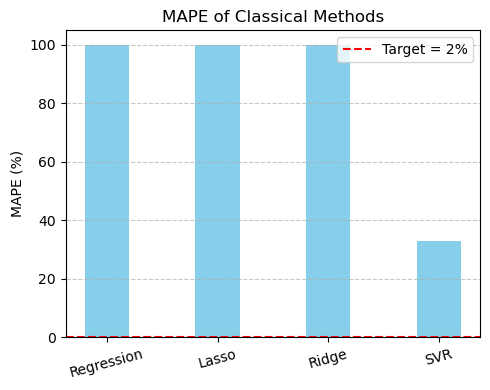

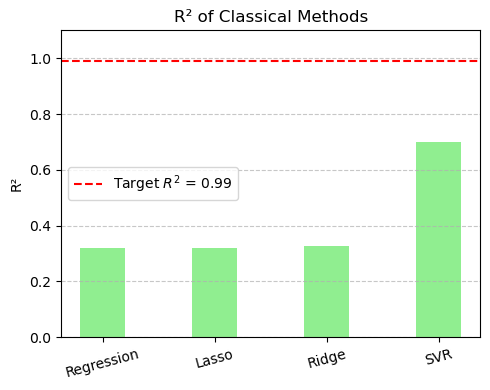

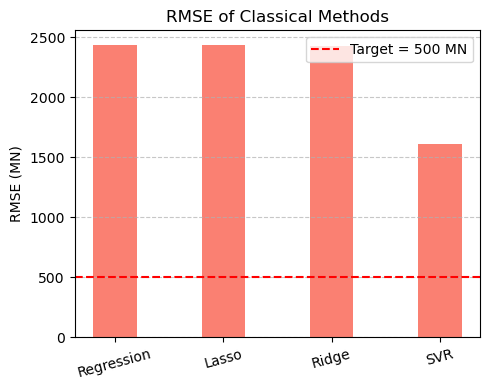

In [19]:
import matplotlib.pyplot as plt

# Common x-axis labels
methods = ['Regression', 'Lasso', 'Ridge', 'SVR']
x = range(len(methods))  # numeric x positions

# Metric values
mape = [99.9747, 99.9182, 99.9748, 32.9009]
r2 = [0.3188, 0.3188, 0.3255, 0.7010]
rmse = [2435.8186, 2435.8186, 2423.7881, 1613.9126]

bar_width = 0.4

# === Plot 1: MAPE ===
plt.figure(figsize=(5, 4))
plt.bar(x, mape, width=bar_width, color='skyblue')
plt.axhline(0.02, color='red', linestyle='--', label='Target = 2%')
plt.title("MAPE of Classical Methods")
plt.ylabel("MAPE (%)")
plt.xticks(x, methods, rotation=15)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Plot 2: R² ===
plt.figure(figsize=(5, 4))
plt.bar(x, r2, width=bar_width, color='lightgreen')
plt.axhline(0.99, color='red', linestyle='--', label='Target $R^2$ = 0.99')
plt.title("R² of Classical Methods")
plt.ylabel("R²")
plt.ylim(0, 1.1)
plt.xticks(x, methods, rotation=15)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Plot 3: RMSE ===
plt.figure(figsize=(5, 4))
plt.bar(x, rmse, width=bar_width, color='salmon')
plt.axhline(500, color='red', linestyle='--', label='Target = 500 MN')
plt.title("RMSE of Classical Methods")
plt.ylabel("RMSE (MN)")
plt.xticks(x, methods, rotation=15)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
